In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pywt
from denoised_series import denoise_all_signal, plot_comparison

panel_data_df = pd.read_pickle('data/panel_data.pkl')
panel_data_df.set_index("index", inplace=True)
panel_data_df.index = pd.to_datetime(panel_data_df.index)
panel_data_df


,Maturity 1,Maturity 2,Maturity 3,Maturity 4,Maturity 5
index,,,,,
1988-01-04,187.5,193.5,198.25,200.0,202.75
1988-01-05,187.5,193.25,197.25,198.25,200.75
1988-01-06,191.0,195.75,199.75,201.75,204.5
1988-01-07,192.75,198.75,202.75,204.5,208.5
1988-01-08,192.5,198.0,202.0,203.5,207.25
...,...,...,...,...,...
2023-12-22,473.0,485.75,495.5,498.25,504.5
2023-12-26,480.25,492.25,501.5,503.5,509.5
2023-12-27,476.5,488.5,498.0,500.25,506.5


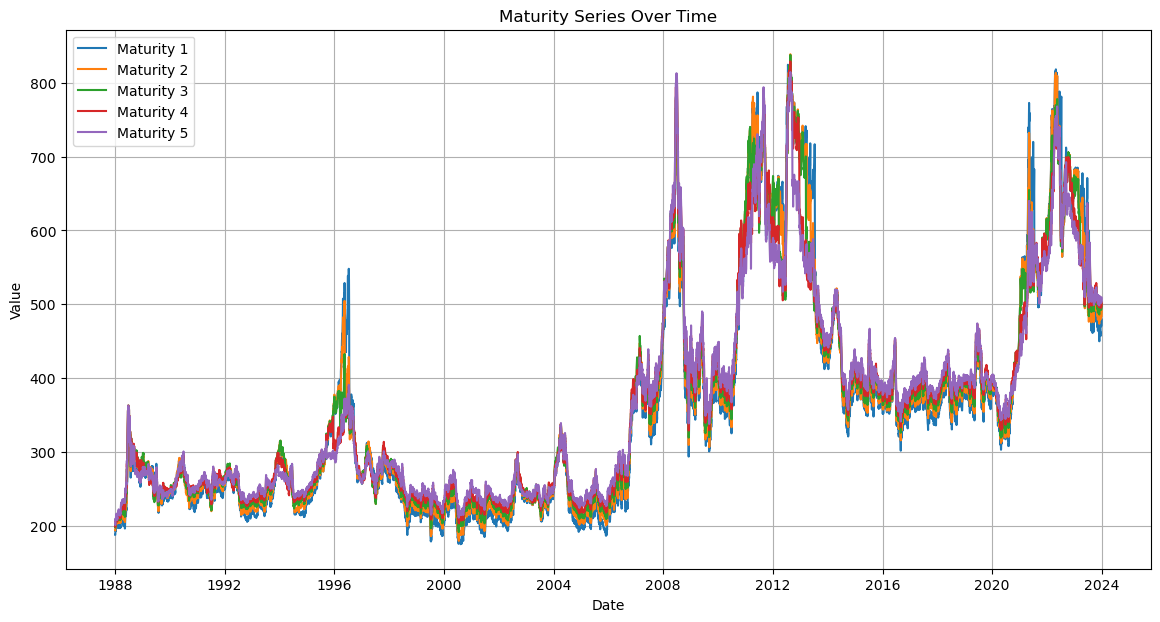

In [2]:
# Plotting the series
plt.figure(figsize=(14, 7))
for column in panel_data_df.columns:
    plt.plot(panel_data_df.index, panel_data_df[column], label=column)

plt.title('Maturity Series Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [3]:
denoised_return_df, prices_reconstructed_df =denoise_all_signal(panel_data_df, wavelet='db1',level = 1)

In [4]:
return_df = panel_data_df.pct_change(1).fillna(0)
signal = return_df.iloc[:,1]
wavelet='db1'
level = 1
# Découper la transformée en ondelettes
coeffs = pywt.wavedec(signal, wavelet)

def madev(d, axis=None):
    """ Mean absolute deviation of a signal """
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

# Calculer le seuil universel
sigma = madev(coeffs[-level])/ 0.6745
#sigma = np.median(np.abs(coeffs[timescale])) / 0.6745
threshold = sigma * np.sqrt(2 * np.log(len(signal)))

# Appliquer le seuil
coeffs_thresholded = [pywt.threshold(c, threshold, mode='soft') for c in coeffs]

# Reconstruire le signal débruité
denoised_signal = pywt.waverec(coeffs_thresholded, wavelet)

[0.08410389842664343, 0.005087881008092181, 0.04621803474068735, 0.04208965735936412, 0.08528849635834798, 0.09790410933301462, 0.07859730737856692, 0.08097847905211414, 0.08014340953748497, 0.08254595631173368, 0.07419691015082071, 0.07784927418580415, 0.07432234049194476, 0.07209136233694846]


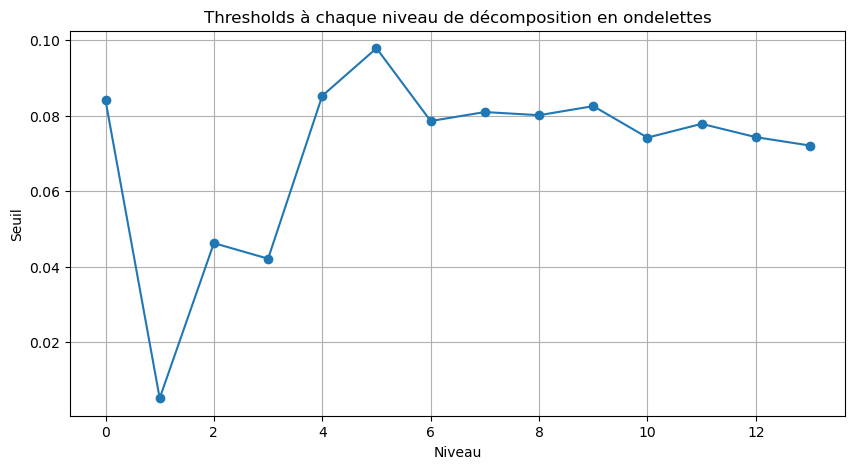

In [12]:
thresholds = []
for i in range(len(coeffs)):
    sigma = madev(coeffs[i])/ 0.6745
    #sigma = np.median(np.abs(coeffs[i])) / 0.6745
    threshold = sigma * np.sqrt(2 * np.log(len(signal)))
    thresholds.append(threshold)
print(thresholds)
# Tracer les seuils
plt.figure(figsize=(10, 5))
plt.plot(thresholds, marker='o')
plt.title('Thresholds à chaque niveau de décomposition en ondelettes')
plt.xlabel('Niveau')
plt.ylabel('Seuil')
plt.grid(True)
plt.show()

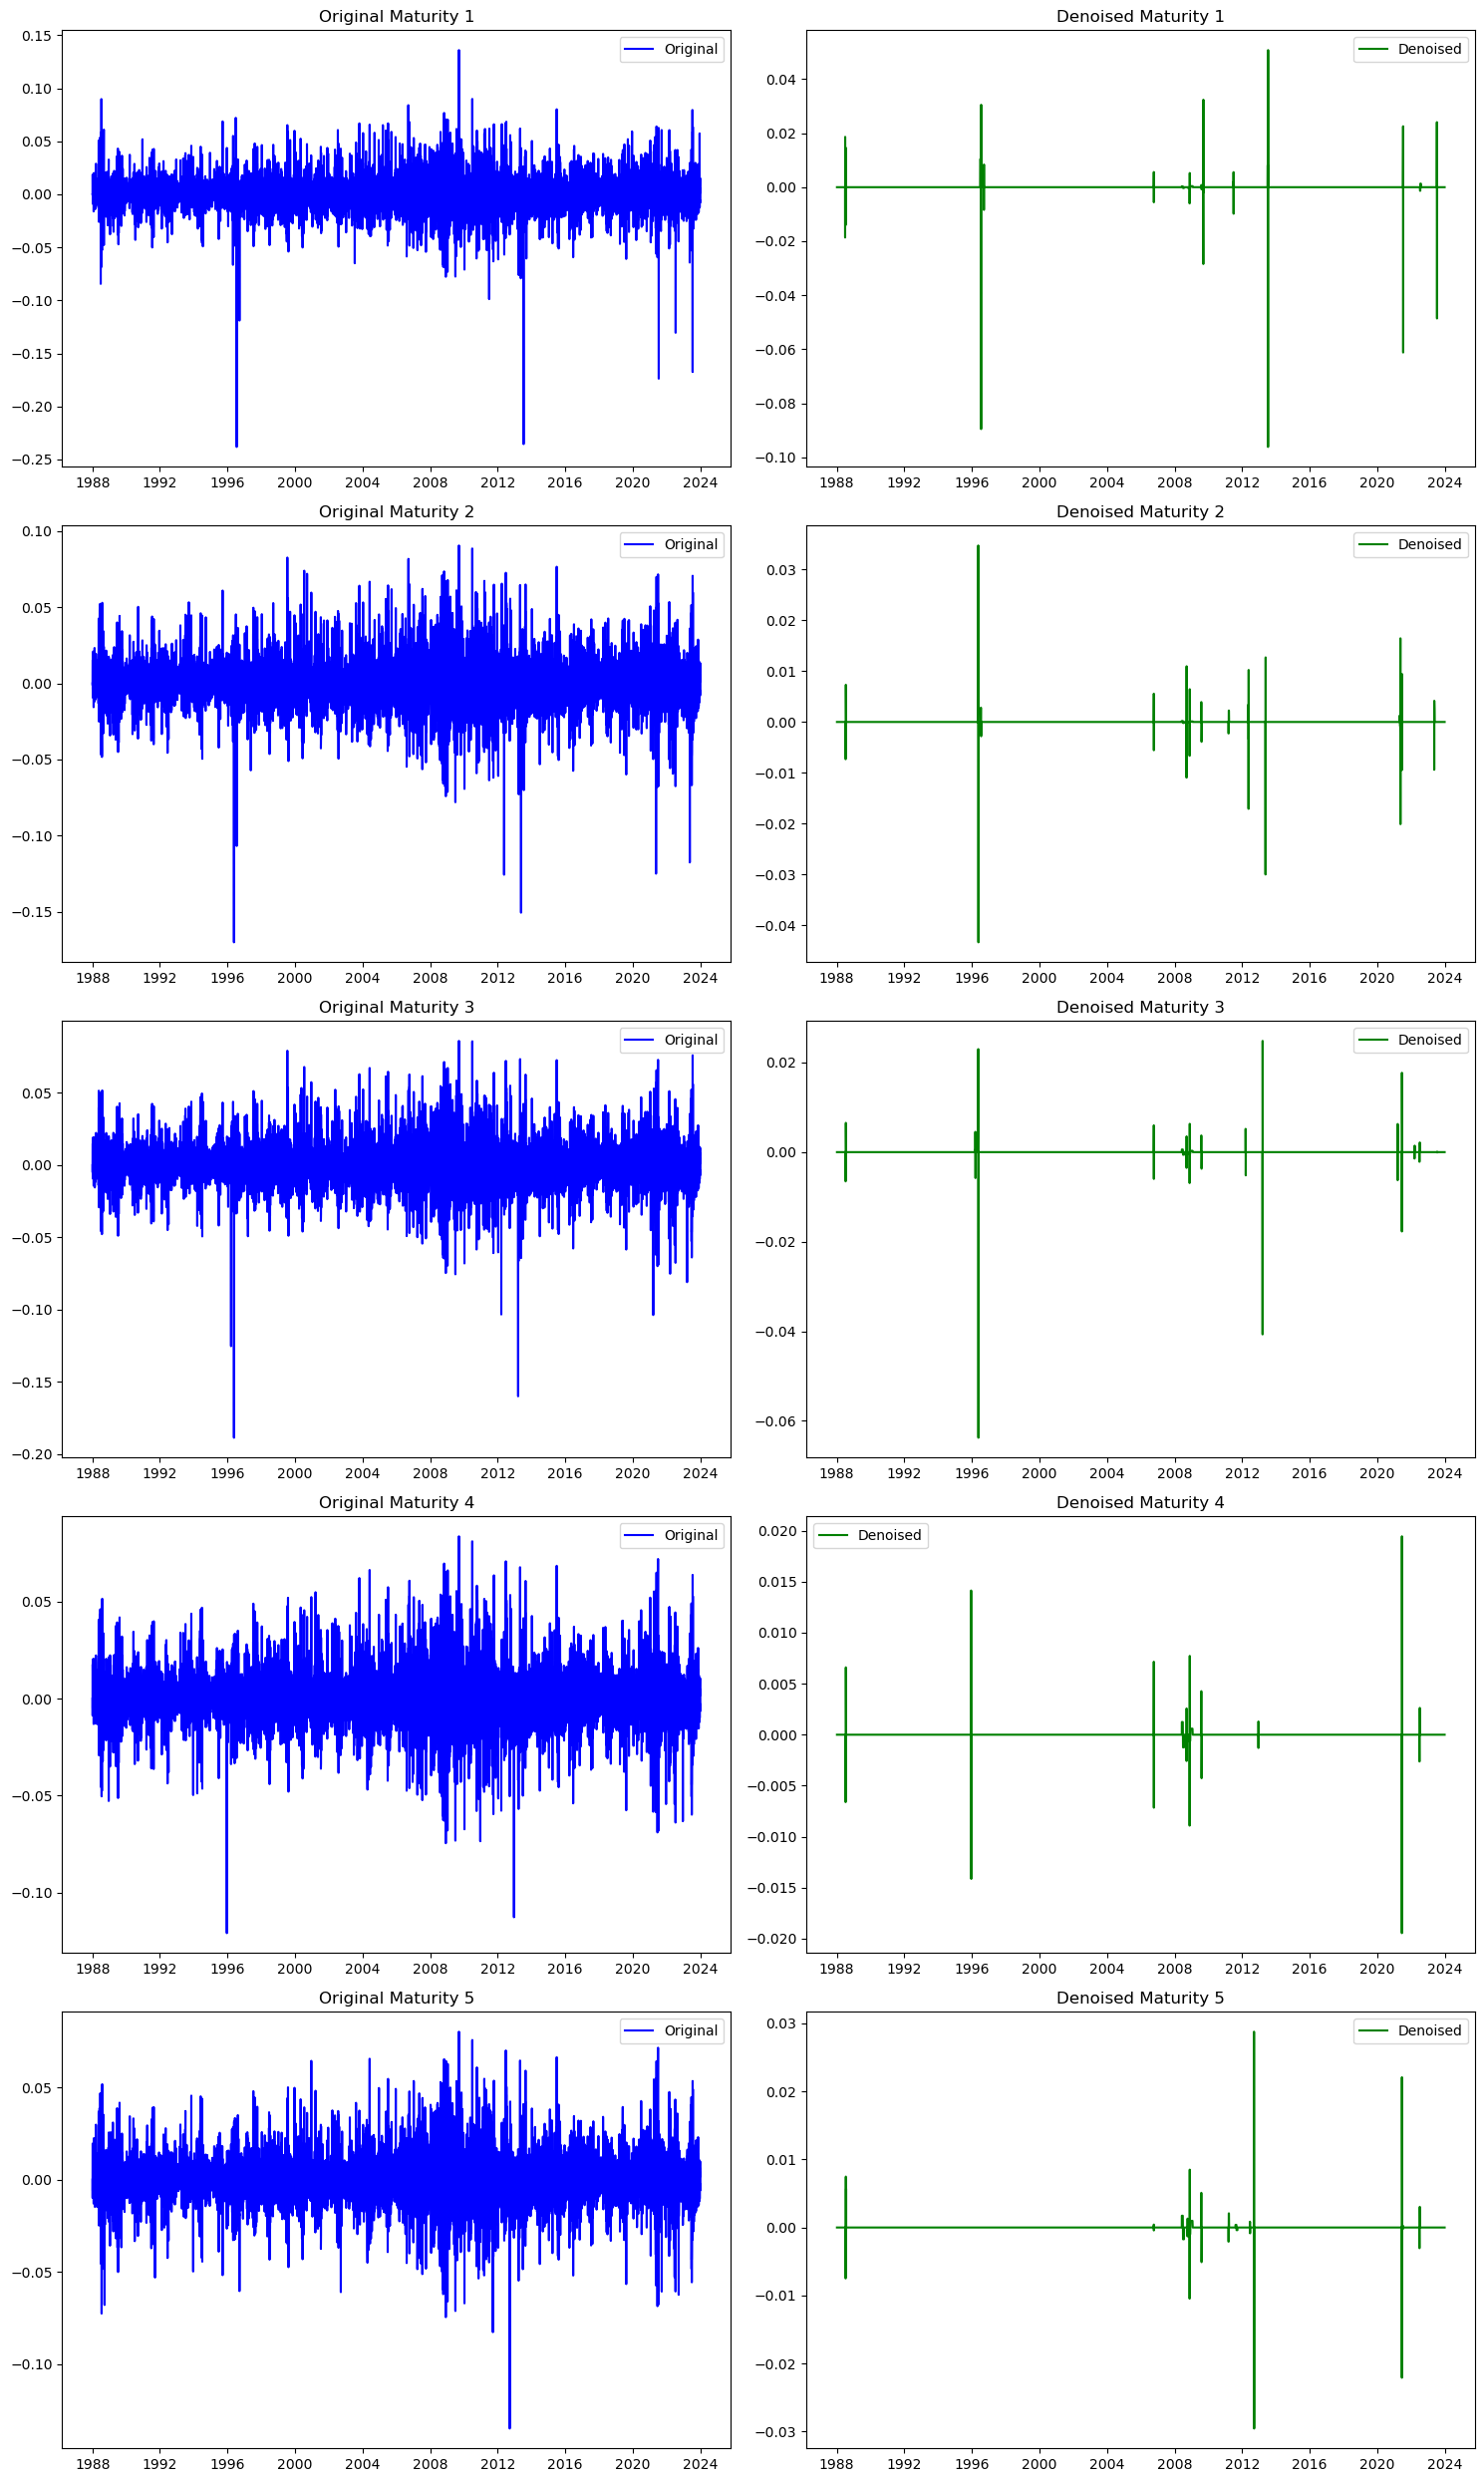

In [6]:
return_df = panel_data_df.pct_change(1).fillna(0)
plot_comparison(return_df, denoised_return_df)

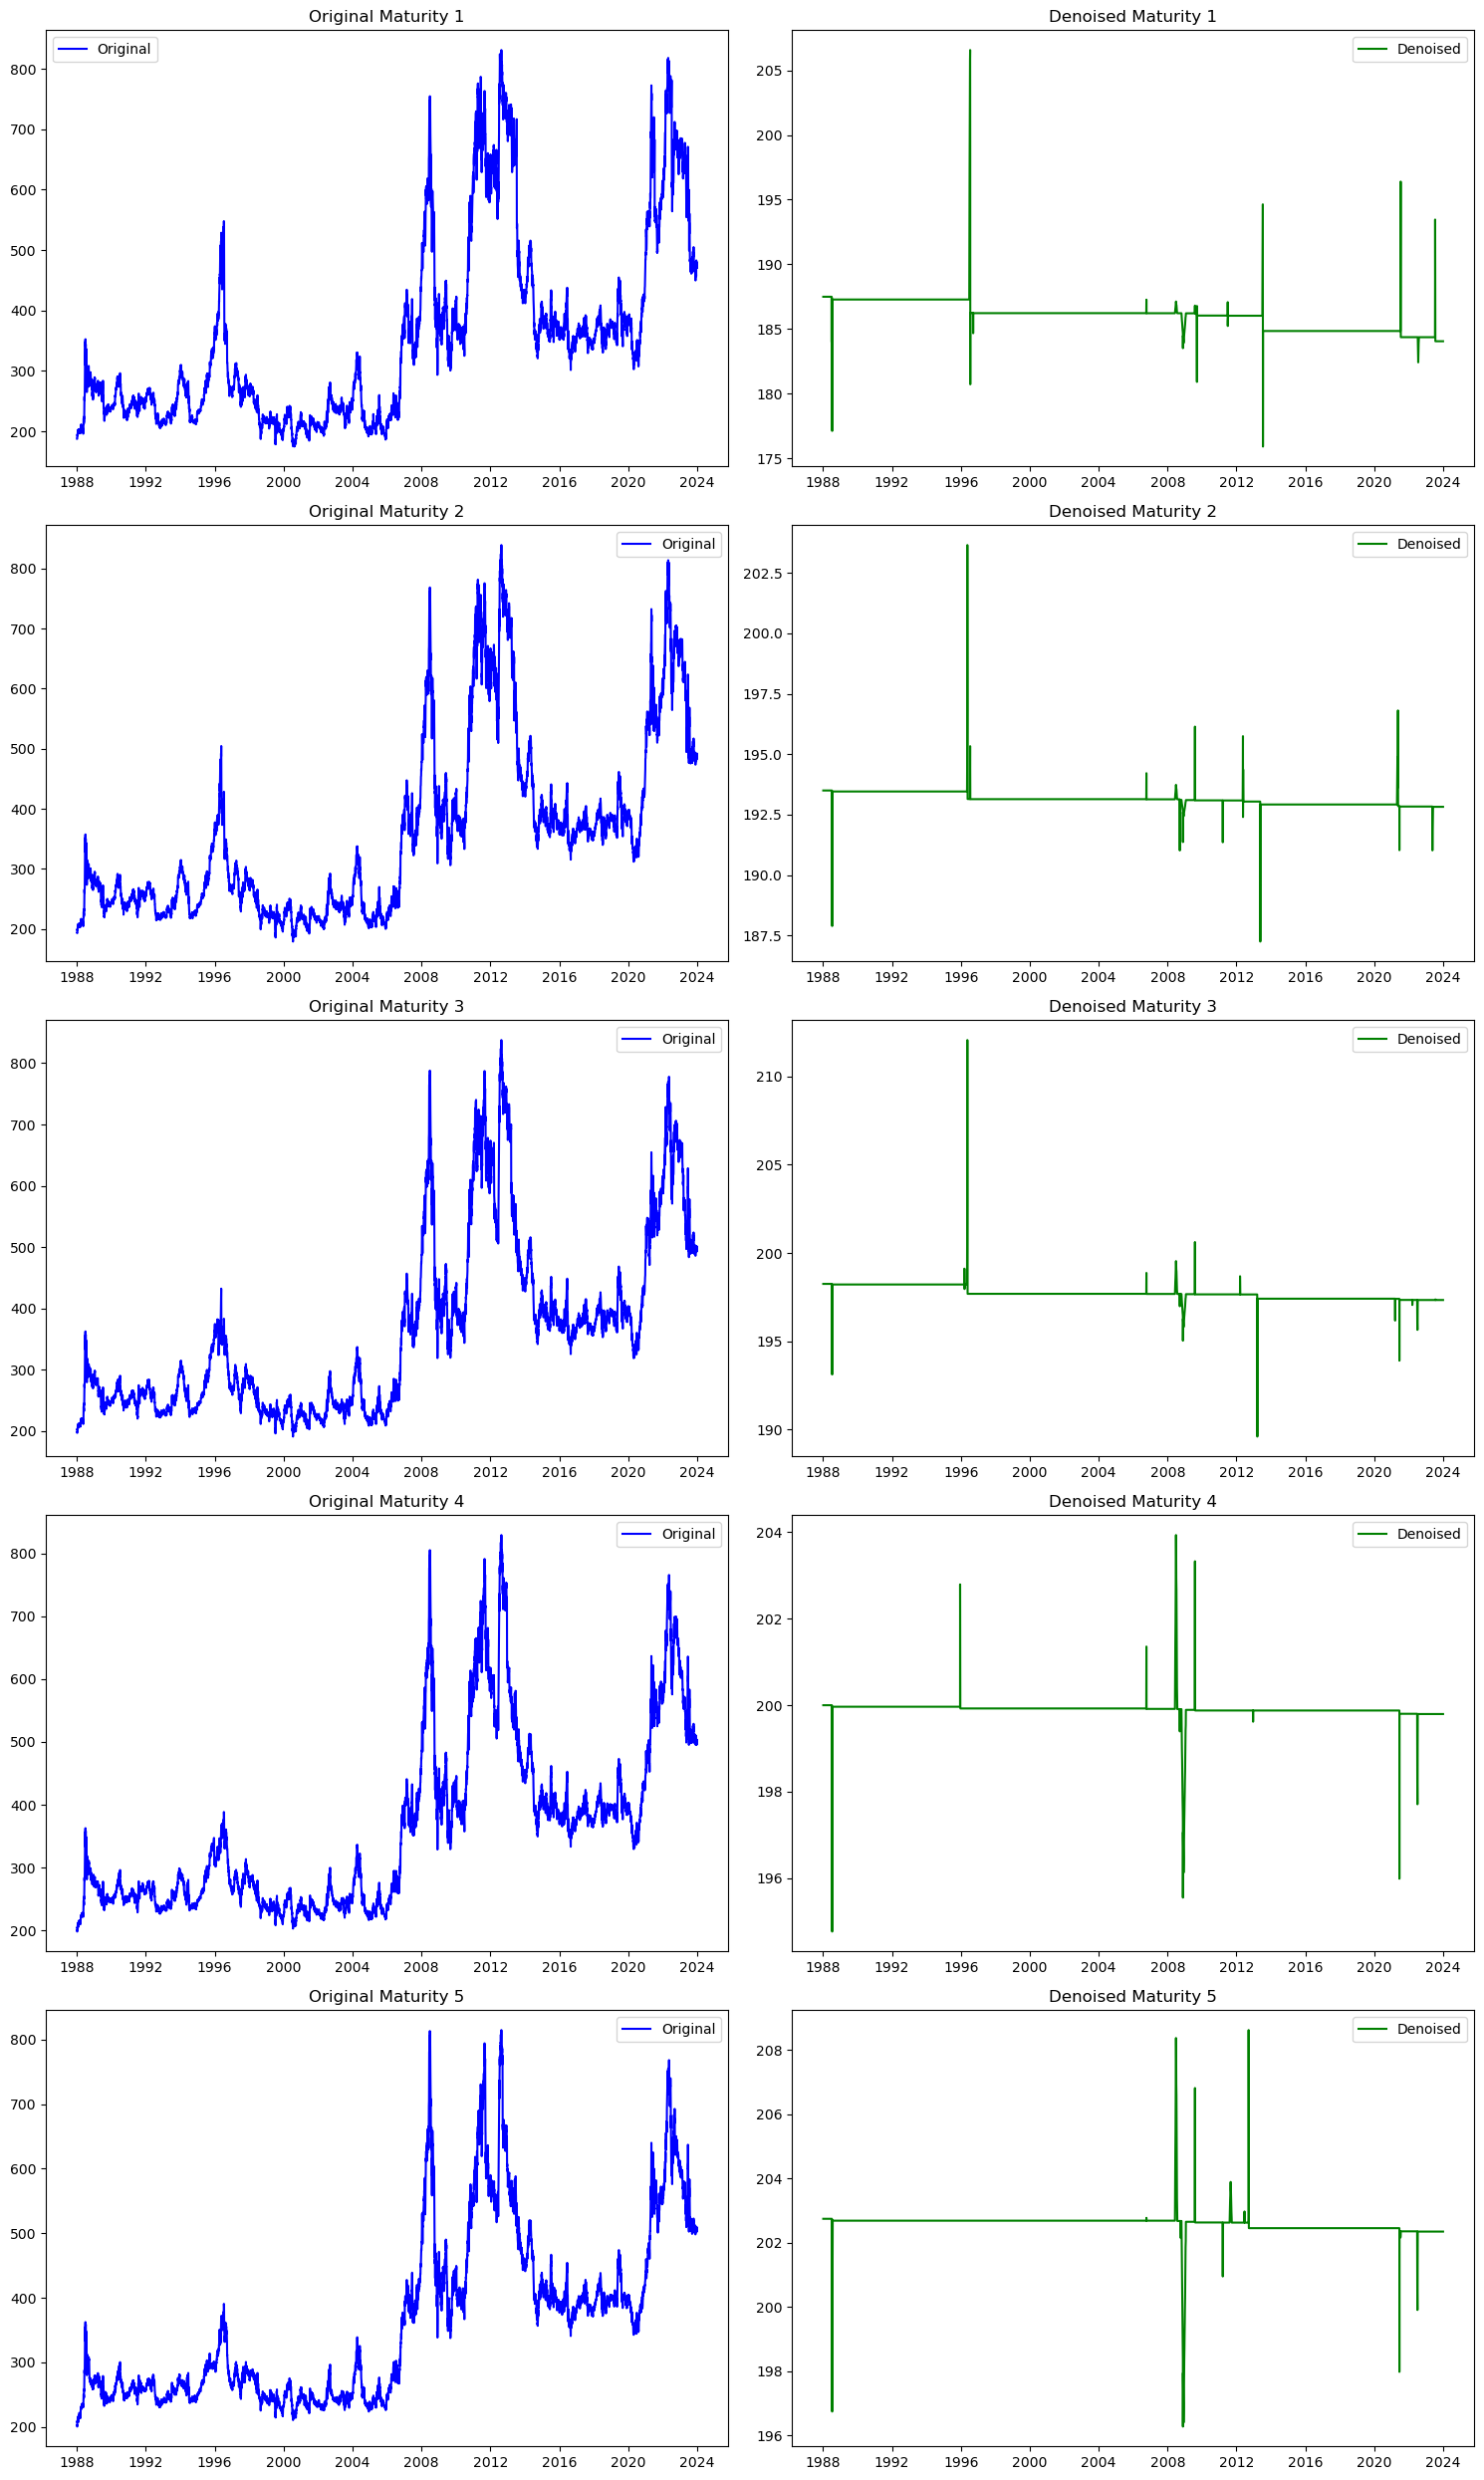

In [7]:
plot_comparison(panel_data_df, prices_reconstructed_df)

#### Estimate coeffs of cyclical function

In [8]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Simuler des données avec moins de bruit et plus de points de données
np.random.seed(0)
t = np.linspace(1, 200, 400)  # Plus de points de données
data = {
    's_t': 3 * np.cos(2 * np.pi * t) + 2 * np.sin(2 * np.pi * t) +
           1.5 * np.cos(4 * np.pi * t) + 1 * np.sin(4 * np.pi * t) +
           np.random.normal(0, 0.25, 400)  # Moins de bruit
}
df = pd.DataFrame(data)

# Préparer les données pour la régression
df['cos_1t'] = np.cos(2 * np.pi * t)
df['sin_1t'] = np.sin(2 * np.pi * t)
df['cos_2t'] = np.cos(4 * np.pi * t)
df['sin_2t'] = np.sin(4 * np.pi * t)

# Régression linéaire
X = df[['cos_1t', 'sin_1t', 'cos_2t', 'sin_2t']]
#X = sm.add_constant(X)  # ajoute une constante
y = df['s_t']

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())


                                 OLS Regression Results                                
Dep. Variable:                    s_t   R-squared (uncentered):                   0.993
Model:                            OLS   Adj. R-squared (uncentered):              0.993
Method:                 Least Squares   F-statistic:                          1.338e+04
Date:                Wed, 15 May 2024   Prob (F-statistic):                        0.00
Time:                        11:15:38   Log-Likelihood:                         -5.9343
No. Observations:                 400   AIC:                                      19.87
Df Residuals:                     396   BIC:                                      35.83
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [9]:
t = np.array(range(1, len(return_df) + 1))
# Préparer les données pour la régression
df = pd.DataFrame({
    'cos_1t': np.cos(2 * np.pi * t/ 200),
    'sin_1t': np.sin(2 * np.pi * t/ 200),
    'cos_2t': np.cos(4 * np.pi * t/ 200),
    'sin_2t': np.sin(4 * np.pi * t/ 200)
}, index=return_df.index) 

# Vérifier que les indices sont alignés
assert y.index.equals(X.index), "Les indices ne sont pas alignés!"

X = sm.add_constant(df)
y = return_df['Maturity 1']

# Exécuter la régression linéaire
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:             Maturity 1   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.343
Date:                Wed, 15 May 2024   Prob (F-statistic):              0.251
Time:                        11:15:38   Log-Likelihood:                 24100.
No. Observations:                9076   AIC:                        -4.819e+04
Df Residuals:                    9071   BIC:                        -4.815e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      1.395      0.1